In [1]:
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from mnist_to_graphs import pad_graph_to_value

#### globals

In [2]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple

N_GRAPHS = 2000
LOG_SCALE = False 
SPLIT = 0.1
LR = 2.e-6
BATCH_SIZE = 32
N_STEPS = 10_000
EVAL_FREQ = 50
PAD_VALUE = 4096 #8128 
F = 32
E = 8

multi_sized = True

#### utils

In [3]:
def print_graph_attributes(g):
  attrs = ["nodes", "edges", "senders", "receivers", "globals", "n_node", "n_edge"]

  for a in attrs:
    val = getattr(g, a)
    print(a, val.shape if val is not None else None)

def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
  # Determine the number of nodes in the graph if not provided
  if n_nodes is None:
    n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

  # Create an empty adjacency matrix
  adj_matrix = np.zeros((n_nodes, n_nodes))

  # Set entries in the adjacency matrix for each edge
  for sender, receiver in zip(sender_indices, receiver_indices):
    adj_matrix[sender, receiver] = 1 
    adj_matrix[receiver, sender] = 1 

  return adj_matrix

def get_dataloaders(
  simulations, 
  parameters, 
  rng, 
  log_scale=False,
  batch_size=BATCH_SIZE, 
  split=SPLIT, 
  repeat=True):
  n_train = int((1. - split) * len(simulations))

  batch_iterator = lambda d: d.batch(batch_size).as_numpy_iterator()

  if log_scale:
    simulations = np.log10(simulations)

  train_dataset = tf.data.Dataset.from_tensor_slices(
    (simulations[:n_train], parameters[:n_train]))
  valid_dataset = tf.data.Dataset.from_tensor_slices(
    (simulations[n_train:], parameters[n_train:]))

  if repeat:
    train_dataset = train_dataset.repeat()
    valid_dataset = valid_dataset.repeat()

  train_dataset = train_dataset.shuffle(n_train, seed=int(rng.sum()))
  train_dataset = batch_iterator(train_dataset)
  valid_dataset = batch_iterator(valid_dataset)
  return train_dataset, valid_dataset

#### data

In [4]:
def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
resolution = 1024 
all_redshifts = [0., 0.5, 1., 2., 3.]
all_R_values = ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

redshifts = all_redshifts[:1]
R_values = all_R_values[:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts:\n{redshifts}\nat resolution x={resolution} with R values:\n{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts:
[0.0]
at resolution x=1024 with R values:
['5.0', '10.0', '15.0', '20.0'].


#### data
* for each moments datavector, make fully connected subgraph for each redshift, then concatenate all the redshift graphs together...

In [5]:
alpha = jnp.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
  os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 

# (z, n, d, R)
all_pdfs = np.load(
    "/Users/Jed.Homer/phd/lfi/jaxdelfi_pdf/data/ALL_PDFS_1024_egg.npy") # downloaded again
all_pdfs_parameters = np.load(
    os.path.join(data_dir, "ALL_PDFS_PARAMS.npy"))

print(all_pdfs.shape)

def get_z_R_from_pdfs(pdfs):
    print(pdfs.shape)
    n_z, n_pdfs, *_ = pdfs.shape
    pdfs_z = jnp.stack([pdfs[z] for z in z_idx])
    pdfs_z_R = jnp.stack([pdfs_z[..., R] for R in R_idx], axis=-1)
    pdfs_z_R = pdfs_z_R.reshape(n_pdfs, len(z_idx), -1)
    return pdfs_z_R

fiducial_pdfs = jnp.load(
    #os.path.join(data_dir, f"fiducial_pdfs_cut_{Rz_string}.npy"))
    os.path.join(data_dir, f"ALL_FIDUCIAL_PDFS_1024.npy"))

latin_pdfs = get_z_R_from_pdfs(all_pdfs)
fiducial_dv = get_z_R_from_pdfs(fiducial_pdfs)
fiducial_dv = fiducial_dv.mean(axis=0)[jnp.newaxis, :]

simulations = latin_pdfs 

print(latin_pdfs.shape)
print(fiducial_dv.shape)

n_sims, parameter_dim = parameters.shape
n_z, n_R, n_m = fiducial_dv.shape
data_dim = np.prod(fiducial_dv.shape)

n_multiples = N_GRAPHS // len(parameters)
# parameters = jnp.tile(parameters, (n_multiples, 1))
# simulations = jnp.tile(simulations, (n_multiples, 1, 1, 1))

parameters.shape, simulations.shape, fiducial_dv.shape

(5, 2000, 99, 7)
(5, 2000, 99, 7)
(5, 15000, 99, 7)
(2000, 1, 396)
(1, 1, 396)


((2000, 5), (2000, 1, 396), (1, 1, 396))

In [6]:
# simulations = all_pdfs_z_R
data_dim = np.prod(simulations.shape[1:])

#### graph builders

In [7]:
def make_subgraphs(pdfs, n_idx=None, deselect_rng=None):
  """ 
    Pass in as many integers as moments for each R, z moment vector 
  """
  # Vmapping, so this is z-axis
  all_g_z = []
  for i, (z, pdf_z) in enumerate(zip(redshifts, pdfs)):
    # Give every node (a moment) R and z information
    n_R, n_pdf_bins = len(R_values), pdfs.shape[-1]
    Rs = jnp.array([float(R) for R in R_values] * int(n_pdf_bins / len(R_values)))
    zs = jnp.array([z] * n_pdf_bins)

    # Randomly de-select nodes  
    node_datas = [pdf_z.flatten(), Rs, zs]
    print([_.shape for _ in node_datas])
    # Concatenate for vmapping ...
    node_features = jnp.stack(node_datas, axis=1)
    node_features_ = node_features
    n_node_per_graph = np.prod(pdf_z.shape)

    g_z = jraph.get_fully_connected_graph(
      node_features=node_features_,
      n_node_per_graph=n_node_per_graph,
      n_graph=1,
      global_features=None,
    add_self_edges=True)
    all_g_z.append(g_z)
  return all_g_z 

def make_graph_from_subgraphs(subgraphs, parameters=None):
  """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
        - for vmapping, may need to remove all "axis adding"...
            -> globals for one graph created as (1, 2) due to added axis 
               so instead make (2,) so they are vmap-stacked ast (B, 2) not (B, 1, 2)
  """
  n_node = sum([g_z.n_node for g_z in subgraphs])
  n_edge = sum([g_z.n_edge for g_z in subgraphs])
  # Note: n_edge is redundant for one redshift + fully connected
  cardinality = jnp.array([n_node, n_edge]).astype(jnp.float32)
  cardinality = cardinality.reshape(1, 2)
  return jraph.GraphsTuple(
    nodes=jnp.concatenate([
      g_z.nodes for g_z in subgraphs]),
    edges=None, 
    # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
    senders=jnp.concatenate([
      g_z.n_node * n + g_z.senders 
      for n, g_z in enumerate(subgraphs)]),
    receivers=jnp.concatenate([
      g_z.n_node * n + g_z.receivers 
      for n, g_z in enumerate(subgraphs)]),
    n_node=n_node,
    n_edge=n_edge,
    globals=cardinality)

In [8]:
def make_graph_from_data(pdfs, n_idx=None, deselect_rng=None):
  """ 
     Pass in as many integers as moments for each R, z moment vector 
  """ 
  print(pdfs.shape)
  n_z, n_R, n_m = pdfs.shape

  # Get fully connected s,r for each subgraph
  n_node_per_graph = np.prod(moments.shape[1:])
  senders, receivers = jnp.meshgrid(
    jnp.arange(n_node_per_graph), 
    jnp.arange(n_node_per_graph))
  # Flatten the senders and receivers.
  senders = senders.flatten()
  receivers = receivers.flatten()
  n_edge = len(senders) # Fully connected

  # Scale and redshift node info matched to flattened moments
  Rs = jnp.array([float(R) for R in R_values] * n_m)
  zs = jnp.array([[z] * n_R * n_m for z in redshifts]).flatten()
  print("R, z", Rs.shape, zs.shape)

  n_node = n_z * n_node_per_graph
  n_edge = n_z * n_edge
  senders = jnp.array([s + n_node_per_graph for s in senders])
  receivers = jnp.array([r + n_node_per_graph for r in receivers])
  print("s/r", senders.shape, receivers.shape)
  # Note: n_edge is redundant for one redshift + fully connected
  cardinality = jnp.array(
    [n_node, n_edge] if n_z > 1 else [n_node],
    dtype=jnp.float32)
  return jraph.GraphsTuple(
    nodes=jnp.stack([
      moments.flatten(), Rs, zs], axis=1),
    edges=None, 
    senders=senders,
    receivers=receivers,
    n_node=n_node,
    n_edge=n_edge,
    globals=cardinality)

In [9]:
rng = jr.PRNGKey(0)

train_dataset, valid_dataset = get_dataloaders(
    simulations, parameters, rng=rng)

x, y = next(train_dataset)
print(x.shape, y.shape)

# Test vmapping a subgraph creation
g = jax.vmap(make_subgraphs)(x)
print("\n")
# Creates a graph tuple with all the graphs in
print_graph_attributes(g[0])

(32, 1, 396) (32, 5)
[(396,), (396,), (396,)]


nodes (32, 396, 3)
edges None
senders (32, 156816)
receivers (32, 156816)
globals None
n_node (32, 1)
n_edge (32, 1)


/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


In [10]:
def make_graph(data, n_idx=None, rng=None):
    # rng, n_idx == None => same sized graphs
    g = make_graph_from_subgraphs(
        make_subgraphs(data, n_idx, rng))
    # comment this line out when doing vmap graph batching
    # vmap apply of net
    # g = g._replace(
    #     nodes=g.nodes.reshape(-1, 3),
    #     globals=g.globals.reshape(2))
    return g

g = jax.vmap(make_graph)(x)
g = g._replace(nodes=g.nodes.reshape(-1, 3))

print_graph_attributes(g)
# print(g.n_node)

[(396,), (396,), (396,)]
nodes (12672, 3)
edges None
senders (32, 156816)
receivers (32, 156816)
globals (32, 1, 2)
n_node (32, 1)
n_edge (32, 1)


In [11]:
def make_graphs(data):

  def make_graph(data, n_idx=None, rng=None):
    # rng, n_idx == None => same sized graphs
    g = make_graph_from_subgraphs(
      make_subgraphs(data, n_idx, rng))
    g = g._replace(
      nodes=g.nodes.reshape(-1, 3),
      globals=g.globals.reshape(2))
    return g
    
  g = jax.vmap(make_graph)(data)
  g = g._replace(
    globals=g.globals.reshape(-1, 2),
    senders=g.senders.flatten(),
    receivers=g.receivers.flatten(),
    n_node=g.n_node.flatten(),
    n_edge=g.n_edge.flatten(),
    nodes=g.nodes.reshape(-1, 3))
  return g

g = make_graphs(x)

print_graph_attributes(g)

[(396,), (396,), (396,)]
nodes (12672, 3)
edges None
senders (5018112,)
receivers (5018112,)
globals (32, 2)
n_node (32,)
n_edge (32,)


In [12]:
# now try deselecting node features in main_graph of subgraphs

def remove_random_nodes(graph, rng, ):
    rng_i, rng_n = jr.split(rng)
    n_nodes = jr.randint(rng_n, )
    # g = g.
    return 

#### model

##### resnet

In [13]:
# Try changing this eps value
layernorm_kwargs = dict(
  axis=1, create_scale=True, create_offset=True, eps=1e-8)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final
    self.use_layernorm = False 

  def __call__(self, x):
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      if self.use_layernorm:
        h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      if self.use_layernorm:
        h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [14]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    # hk.Linear(F), 
    LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), 
    # hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F], activate_final=True),
    # hk.nets.MLP([F, F, F], activation=jax.nn.tanh, activate_final=True),
    hk.Linear(parameter_dim, with_bias=True)]) # output summary of parameter dim
  return net(feats)

def LayerNormLinear(x):
  h = hk.LayerNorm(**layernorm_kwargs)(x)
  return hk.Linear(E, with_bias=False)(h)

def net_fn(graph: Graph) -> Graph:
  embedder = jraph.GraphMapFeatures(
    embed_node_fn=LayerNormLinear, 
    embed_global_fn=LayerNormLinear) 
  graph = embedder(graph)
  for _ in range(1):
    net = jraph.GraphNetwork(
      update_edge_fn=None,
      update_node_fn=node_update_fn,
      update_global_fn=update_global_fn)
    graph = net(graph)
  return graph

#### train

In [15]:
train_dataset, valid_dataset = get_dataloaders(
    simulations, parameters, rng, log_scale=LOG_SCALE)

d, y = next(train_dataset)

print("data", d.shape, "\n")

g = make_graph(d[0])
G = jax.vmap(make_graph)(d)
%timeit jax.vmap(make_graph)(d)

print_graph_attributes(g)
print("\n")
print_graph_attributes(G)

print("\n")

gs = [make_graph(d_) for d_ in d]
%timeit jraph.batch(gs)
gs = jraph.batch(gs)
print_graph_attributes(gs)

data (32, 1, 396) 

[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
[(396

#### trainer functions

In [16]:
def compute_loss(
  params: hk.Params, 
  graph: Graph, 
  label: Array,
  net: Graph) -> Tuple[Array, Array]:
  # pred_graph = net.apply(params, graph)
  pred_graph = jax.vmap(net.apply, in_axes=(None, 0))(params, graph)
  preds = pred_graph.globals
  mask = jraph.get_graph_padding_mask(pred_graph)
  loss = (jnp.square(jnp.subtract(preds, label)) * mask[:, None]).mean()
  return loss, (None,)
 
@jax.jit
def get_graph_(d):
  # return jraph.batch([make_graph(d_) for d_ in d])
  return jax.vmap(make_graph)(d)

def train(
  simulations: Array, 
  parameters: Array, 
  num_train_steps: int,
  patience: int = 50) -> Tuple[hk.Params, List]:
  """
    Pad only edges/nodes/senders/receivers.
    - these change size with number of nodes in graph
    - global attr constant shape for any graph with whatever n_nodes
  """

  rng = jr.PRNGKey(0)

  net = hk.without_apply_rng(hk.transform(net_fn))
    
  d, y = jnp.ones_like(fiducial_dv), jnp.ones(len(alpha))#next(train_dataset)
  graph = get_graph_(d)
  graph = make_graph(d[0])
  print("init graph")
  print_graph_attributes(graph)

  # Initialize the network and optimizer.
  params = net.init(rng, graph)
  opt_init, opt_update = optax.adabelief(LR)
  opt_state = opt_init(params)
  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")
  print(f"n_params = {hk.data_structures.tree_size(params)}")

  compute_loss_fn = partial(compute_loss, net=net)
  eval_fn = jax.jit(compute_loss_fn)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_fn, has_aux=True))
  
  counter = 0
  best_loss = jnp.inf
  train_losses, valid_losses = [], []
  for s in range(num_train_steps):
    epoch_train_losses, epoch_valid_losses = [], []

    train_dataset, valid_dataset = get_dataloaders(
      simulations, 
      parameters, 
      rng, 
      log_scale=LOG_SCALE, 
      batch_size=BATCH_SIZE, 
      repeat=False)

    for d, y in train_dataset:
      # Train
      # d, y = next(train_dataset)
      graph = get_graph_(d)

      (train_loss, (_)), grad = compute_loss_fn(params, graph, y)
      updates, opt_state = opt_update(grad, opt_state, params)
      params = optax.apply_updates(params, updates)

      epoch_train_losses.append(train_loss)

    for d, y in valid_dataset:
      # Validate
      # d, y = next(valid_dataset)
      graph = get_graph_(d)
      valid_loss, _ = eval_fn(params, graph, y)

      epoch_valid_losses.append(valid_loss)

    epoch_valid_loss = np.mean(epoch_valid_losses) 
    train_losses.append(np.mean(epoch_train_losses))
    valid_losses.append(epoch_valid_loss)

    if s % EVAL_FREQ == 0:
      print(f'\rstep: {s:06d}, L_t: {train_loss:.4f} L_v: {valid_loss:.4f}', end="")
    
    if epoch_valid_loss < best_loss:
        best_loss = epoch_valid_loss
        counter = 0
    else:
        counter += 1
        if counter > patience:
          print(f"\nPatience met at epoch {s} with L_v={epoch_valid_loss:.2E}")
          break
    

  return params, np.asarray([train_losses, valid_losses])

#### train

In [17]:
import time
t0 = time.time()

params, losses = train(simulations, parameters, num_train_steps=N_STEPS)

print(f"\n {(time.time() - t0) / 60.:.2f} mins.")

[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
init graph
nodes (396, 3)
edges None
senders (156816,)
receivers (156816,)
globals (1, 2)
n_node (1,)
n_edge (1,)
n_params = 1.47E+04
n_params = 14743
[(396,), (396,), (396,)]
[(396,), (396,), (396,)]
step: 000050, L_t: 0.0126 L_v: 0.0113093.7266
Patience met at epoch 97 with L_v=1.05E-02

 2.90 mins.


In [18]:
# def randomly_select_nodes()

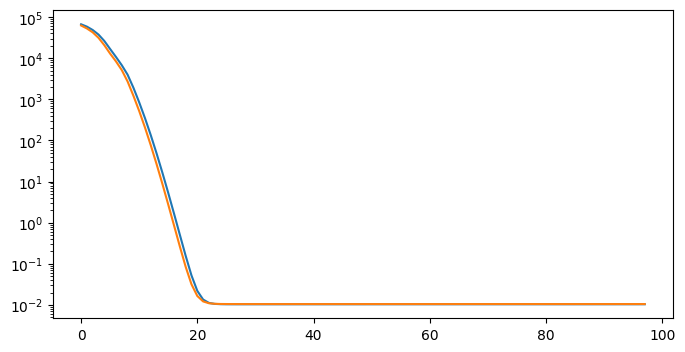

In [19]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8.,4.))
L_t, L_v = losses
# steps = range(0, N_STEPS, EVAL_FREQ)
# ax.semilogy(steps, L_t)
# ax.semilogy(steps, L_v)
ax.semilogy(L_t)
ax.semilogy(L_v)
plt.show()

In [20]:
all_graphs = get_graph_(simulations[:2000])

[(396,), (396,), (396,)]


In [21]:
print_graph_attributes(all_graphs)

nodes (2000, 396, 3)
edges None
senders (2000, 156816)
receivers (2000, 156816)
globals (2000, 1, 2)
n_node (2000, 1)
n_edge (2000, 1)


In [22]:
# fiducial_subgraphs = make_subgraphs(fiducial_dv)
# fiducial_graph = make_graph_from_subgraphs(fiducial_subgraphs, alpha[None, :])

fiducial_graph = jax.vmap(make_graph)(fiducial_dv)

[(396,), (396,), (396,)]


In [23]:
net = hk.without_apply_rng(hk.transform(net_fn))

In [27]:
all_graphs_out = jax.vmap(net.apply, in_axes=(None, 0))(params, all_graphs)
fiducial_graph_out = jax.vmap(net.apply, in_axes=(None, 0))(params, fiducial_graph)

preds = all_graphs_out.globals.squeeze()
fiducial_preds = fiducial_graph_out.globals.squeeze(0)

preds.shape, fiducial_preds.shape 

((2000, 5), (1, 5))

In [28]:
n_train = int((1. - 0.1) * N_GRAPHS)

c = jnp.zeros(N_GRAPHS)
c = c.at[:n_train].set(jnp.ones(n_train))

(2000, 2) (2000, 2) (1, 5)


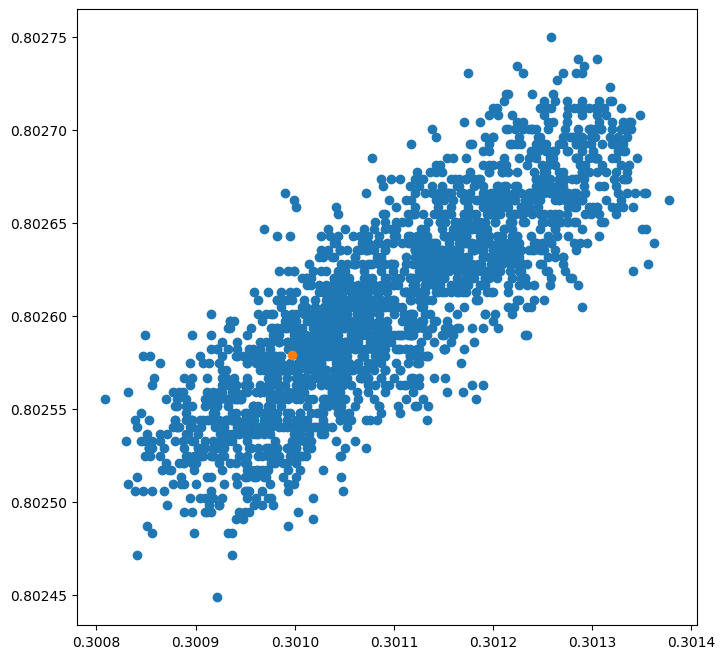

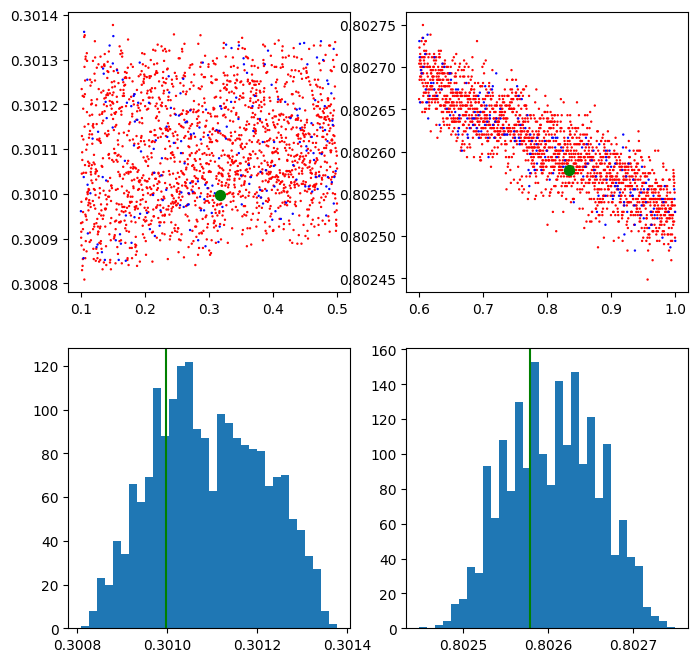

In [29]:
target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:N_GRAPHS, target_idx]

print(pred_targets.shape, parameter_targets.shape, fiducial_preds.shape)

fig, ax = plt.subplots(figsize=(8., 8.), dpi=100)
ax.scatter(*pred_targets.T)
ax.scatter(*fiducial_preds[:, target_idx].T)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]

cmap = "bwr"
ax.scatter(parameter_targets[:2000, 0], pred_targets[:, 0], c=c, cmap=cmap, s=0.5)
ax.scatter(alpha[None, :][:, 0], fiducial_preds[:, 0], s=50., color="green")
ax = axs[0, 1]
ax.scatter(parameter_targets[:2000, 1], pred_targets[:, 1], c=c, cmap=cmap, s=0.5)
ax.scatter(alpha[None, :][:, 4], fiducial_preds[:, 4], s=50., color="green")
ax = axs[1, 0]
# ax.hist(parameter_targets[:2000, 0], histtype="step")
ax.hist(pred_targets[:, 0], bins=32)
ax.axvline(fiducial_preds[:, 0], color="green")
ax = axs[1, 1]
# ax.hist(parameter_targets[:2000, 1], histtype="step")
ax.hist(pred_targets[:, 1], bins=32)
ax.axvline(fiducial_preds[:, 4], color="green")
plt.show()

senders and receivers are constant through application of graph interaction network

In [ ]:
cmap = "Purples"

target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:N_GRAPHS, target_idx]

print(pred_targets.shape, parameter_targets.shape)
print(min(all_n_nodes), max(all_n_nodes))

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]

ax.scatter(parameter_targets[:, 0], pred_targets[:, 0], c=all_n_nodes, s=0.5, cmap=cmap)
ax.scatter(alpha[None, :][:, 0], fiducial_preds[:, 0], s=50.)
ax = axs[0, 1]
ax.scatter(parameter_targets[:, 1], pred_targets[:, 1], c=all_n_nodes, s=0.5, cmap=cmap)
ax.scatter(alpha[None, :][:, 4], fiducial_preds[:, 4], s=50.)
ax = axs[1, 0]
ax.hist(parameter_targets[:, 0], histtype="step")
ax.hist(pred_targets[:, 0])
ax.axvline(fiducial_preds[:, 0], color="blue")
ax = axs[1, 1]
ax.hist(parameter_targets[:, 1], histtype="step")
ax.hist(pred_targets[:, 1])
ax.axvline(fiducial_preds[:, 4], color="blue")
plt.show()

(2000, 2) (2000, 2)


NameError: name 'all_n_nodes' is not defined

In [ ]:
fiducial_preds.shape

(1, 5)

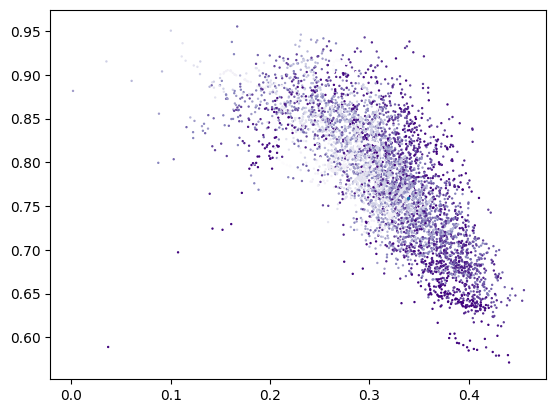

In [ ]:
plt.figure()
plt.scatter(*pred_targets.T, s=0.5, c=all_n_nodes, cmap=cmap)
plt.scatter(*fiducial_preds[:, target_idx].T, s=2.)
plt.show()

In [ ]:

  # Creating graph tuples.

  # Creates a GraphsTuple from scratch containing a single graph.
  # The graph has 3 nodes and 2 edges.
  # Each node has a 4-dimensional feature vector.
  # Each edge has a 5-dimensional feature vector.
  # The graph itself has a 6-dimensional feature vector.
  single_graph = jraph.GraphsTuple(
      n_node=np.asarray([3]), n_edge=np.asarray([2]),
      nodes=np.ones((3, 4)), edges=np.ones((2, 5)),
      globals=np.ones((1, 6)),
      senders=np.array([0, 1]), receivers=np.array([2, 2]))
  print("Single graph")
  print_graph_attributes(single_graph)

  # Creates a GraphsTuple from scratch containing a single graph with nested
  # feature vectors.
  # The graph has 3 nodes and 2 edges.
  # The feature vector can be arbitrary nested types of dict, list and tuple,
  # or any other type you registered with jax.tree_util.register_pytree_node.
  nested_graph = jraph.GraphsTuple(
      n_node=np.asarray([3]), 
      n_edge=np.asarray([2]),
      nodes=np.ones((3, 4)), 
      edges=np.ones((2, 5)),
      globals=np.ones((1, 6)),
      senders=np.array([0, 1]), 
      receivers=np.array([2, 2]))
  print("Nested graph")
  print_graph_attributes(nested_graph)

  # Creates a GraphsTuple from scratch containing 2 graphs using an implicit
  # batch dimension.
  # The first graph has 3 nodes and 2 edges.
  # The second graph has 1 node and 1 edge.
  # Each node has a 4-dimensional feature vector.
  # Each edge has a 5-dimensional feature vector.
  # The graph itself has a 6-dimensional feature vector.
  implicitly_batched_graph = jraph.GraphsTuple(
      n_node=np.asarray([3, 1]), n_edge=np.asarray([2, 1]),
      nodes=np.ones((4, 4)), edges=np.ones((3, 5)),
      globals=np.ones((2, 6)),
      senders=np.array([0, 1, 3]), receivers=np.array([2, 2, 3]))
  print("Implicitly batched graph")
  print_graph_attributes(implicitly_batched_graph)

  # Batching graphs can be challenging. There are in general two approaches:
  # 1. Implicit batching: Independent graphs are combined into the same
  #    GraphsTuple first, and the padding is added to the combined graph.
  # 2. Explicit batching: Pad all graphs to a maximum size, stack them together
  #    using an explicit batch dimension followed by jax.vmap.
  # Both approaches are shown below.

  # Creates a GraphsTuple from two existing GraphsTuple using an implicit
  # batch dimension.
  # The GraphsTuple will contain three graphs.
  implicitly_batched_graph = jraph.batch(
      [single_graph, implicitly_batched_graph])
  print("Implicitly batched graph")
  print_graph_attributes(implicitly_batched_graph)

  # Creates multiple GraphsTuples from an existing GraphsTuple with an implicit
  # batch dimension.
  graph_1, graph_2, graph_3 = jraph.unbatch(implicitly_batched_graph)
  print("Unbatched graphs") 
  print_graph_attributes(graph_1)
  print_graph_attributes(graph_2)
  print_graph_attributes(graph_3)

  # Creates a padded GraphsTuple from an existing GraphsTuple.
  # The padded GraphsTuple will contain 10 nodes, 5 edges, and 4 graphs.
  # Three graphs are added for the padding.
  # First a dummy graph which contains the padding nodes and edges and secondly
  # two empty graphs without nodes or edges to pad out the graphs.
  padded_graph = jraph.pad_with_graphs(
      single_graph, n_node=10, n_edge=5, n_graph=4)
  print("Padded graph") 
  print_graph_attributes(padded_graph)

  # Creates a GraphsTuple from an existing padded GraphsTuple.
  # The previously added padding is removed.
  single_graph = jraph.unpad_with_graphs(padded_graph)
  print("Unpadded graph") 
  print_graph_attributes(single_graph)

  # Creates a GraphsTuple containing 2 graphs using an explicit batch
  # dimension.
  # An explicit batch dimension requires more memory, but can simplify
  # the definition of functions operating on the graph.
  # Explicitly batched graphs require the GraphNetwork to be transformed
  # by jax.vmap.
  # Using an explicit batch requires padding all feature vectors to
  # the maximum size of nodes and edges.
  # The first graph has 3 nodes and 2 edges.
  # The second graph has 1 node and 1 edge.
  # Each node has a 4-dimensional feature vector.
  # Each edge has a 5-dimensional feature vector.
  # The graph itself has a 6-dimensional feature vector.
  explicitly_batched_graph = jraph.GraphsTuple(
      n_node=np.asarray([[3], [1]]), n_edge=np.asarray([[2], [1]]),
      nodes=np.ones((2, 3, 4)), edges=np.ones((2, 2, 5)),
      globals=np.ones((2, 1, 6)),
      senders=np.array([[0, 1], [0, -1]]),
      receivers=np.array([[2, 2], [0, -1]]))
  print("Explicitly batched graph") 
  print_graph_attributes(explicitly_batched_graph)

Single graph
nodes (3, 4)
edges (2, 5)
senders (2,)
receivers (2,)
globals (1, 6)
n_node (1,)
n_edge (1,)
Nested graph
nodes (3, 4)
edges (2, 5)
senders (2,)
receivers (2,)
globals (1, 6)
n_node (1,)
n_edge (1,)
Implicitly batched graph
nodes (4, 4)
edges (3, 5)
senders (3,)
receivers (3,)
globals (2, 6)
n_node (2,)
n_edge (2,)
Implicitly batched graph
nodes (7, 4)
edges (5, 5)
senders (5,)
receivers (5,)
globals (3, 6)
n_node (3,)
n_edge (3,)
Unbatched graphs
nodes (3, 4)
edges (2, 5)
senders (2,)
receivers (2,)
globals (1, 6)
n_node (1,)
n_edge (1,)
nodes (3, 4)
edges (2, 5)
senders (2,)
receivers (2,)
globals (1, 6)
n_node (1,)
n_edge (1,)
nodes (1, 4)
edges (1, 5)
senders (1,)
receivers (1,)
globals (1, 6)
n_node (1,)
n_edge (1,)
Padded graph
nodes (10, 4)
edges (5, 5)
senders (5,)
receivers (5,)
globals (4, 6)
n_node (4,)
n_edge (4,)
Unpadded graph
nodes (3, 4)
edges (2, 5)
senders (2,)
receivers (2,)
globals (1, 6)
n_node (1,)
n_edge (1,)
Explicitly batched graph
nodes (2, 3, 4)


In [ ]:
import dataclasses
import jax

def register_pytree_node_dataclass(cls):
  _flatten = lambda obj: jax.tree_util.tree_flatten(dataclasses.asdict(obj))
  _unflatten = lambda d, children: cls(**d.unflatten(children))
  jax.tree_util.register_pytree_node(cls, _flatten, _unflatten)
  return cls

@register_pytree_node_dataclass
@dataclasses.dataclass
class MomentNode:
  R: Array 
  z: Array 
  m_n: Array 

d = MomentNode(
  jnp.ones((3, 2)),
  jnp.ones((3, 5)),
  jnp.ones((3, 1)))
leaves, treedef = jax.tree_util.tree_flatten(d)
treedef.unflatten(leaves)

print("before")
print(d)
print("after")
jax.tree_util.tree_map(lambda x: 2. * x + 1., d)

before
MomentNode(R=DeviceArray([[1., 1.],
             [1., 1.],
             [1., 1.]], dtype=float32), z=DeviceArray([[1., 1., 1., 1., 1.],
             [1., 1., 1., 1., 1.],
             [1., 1., 1., 1., 1.]], dtype=float32), m_n=DeviceArray([[1.],
             [1.],
             [1.]], dtype=float32))
after


MomentNode(R=DeviceArray([[3., 3.],
             [3., 3.],
             [3., 3.]], dtype=float32), z=DeviceArray([[3., 3., 3., 3., 3.],
             [3., 3., 3., 3., 3.],
             [3., 3., 3., 3., 3.]], dtype=float32), m_n=DeviceArray([[3.],
             [3.],
             [3.]], dtype=float32))

In [ ]:
g = jraph.GraphsTuple(
  n_node=np.asarray([3]), 
  n_edge=np.asarray([2]),
  nodes=d, 
  edges=np.ones((2, 5)),
  globals=np.ones((1, 6)),
  senders=np.array([0, 1]), 
  receivers=np.array([2, 2]))

# Replace just the nodes with a tree map over
# the MomentNode node attribute
g_ = g._replace(nodes=jax.tree_map(lambda x: 2. * x + 1., g.nodes))

print(g.nodes)
print(g.edges)
print(g_.nodes)
print(g_.edges)

MomentNode(R=DeviceArray([[1., 1.],
             [1., 1.],
             [1., 1.]], dtype=float32), z=DeviceArray([[1., 1., 1., 1., 1.],
             [1., 1., 1., 1., 1.],
             [1., 1., 1., 1., 1.]], dtype=float32), m_n=DeviceArray([[1.],
             [1.],
             [1.]], dtype=float32))
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
MomentNode(R=DeviceArray([[3., 3.],
             [3., 3.],
             [3., 3.]], dtype=float32), z=DeviceArray([[3., 3., 3., 3., 3.],
             [3., 3., 3., 3., 3.],
             [3., 3., 3., 3., 3.]], dtype=float32), m_n=DeviceArray([[3.],
             [3.],
             [3.]], dtype=float32))
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
